In [ ]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 501 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [ ]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())


# prices_df.to_csv("sp500_prices_2010_2024.csv")
# volumes_df.to_csv("sp500_volumes_2010_2024.csv")

501 hisse icin veri indiriliyor...


[**                     4%                       ]  22 of 501 completed$SOLS: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*****************     35%                       ]  177 of 501 completed$Q: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[**********************86%****************       ]  429 of 501 completed$SNDK: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")
[*********************100%***********************]  501 of 501 completed

3 Failed downloads:
['SOLS', 'Q', 'SNDK']: possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn't exist for startDate = 1262322000, endDate = 1735621200")


DATA DOWNLOADED
Shape of data: (3773, 446)
Ticker      BLDR   INCY        AWK         BG        TRV         PH        NI  \
Date                                                                            
2010-01-04  3.77   9.50  15.696339  43.723572  34.303448  41.591511  3.522926   
2010-01-05  3.59  10.27  15.855726  45.231731  33.490799  41.393158  3.513841   
2010-01-06  3.60  11.00  15.938890  46.699341  33.015602  41.217709  3.472956   
2010-01-07  3.57  10.82  15.973536  47.970802  33.490799  41.705936  3.429797   
2010-01-08  3.54  10.94  15.938890  48.214272  33.442589  42.888378  3.411628   

Ticker           SPGI    ON       PSKY  ...        FRT       MDLZ      EBAY  \
Date                                    ...                                   
2010-01-04  25.785328  8.87  10.735094  ...  38.977909  12.608082  8.952066   
2010-01-05  25.808342  8.79  10.682360  ...  38.931374  13.224010  8.858429   
2010-01-06  25.578192  8.90  10.343354  ...  38.826714  13.315940  8.8022

In [ ]:
def calculate_returns(prices_df):
    """
    Calculate log returns.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    return returns.dropna()

def get_pca_residuals(returns_df, n_components=5, window=252):

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    residuals[:] = np.nan # Başlangıçta boş

    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    # veri setini array'lere dönüştürelim.
    data_values = returns_df.values
    index_values = returns_df.index
    columns_values = returns_df.columns

    # PCA Modeli
    pca = PCA(n_components=n_components)

    # Döngü: Her gün için geçmiş 'window' kadar veriyi alıp PCA uygula.
    for t in range(window, len(returns_df)):
        
        # Geçmiş veriyi al (t-window'dan t'ye kadar)
        window_data = data_values[t-window : t]
        
        # Sütun bazında NaN var mı kontrol et (Bazen hisseler o dönem işlem görmemiş olabilir)
        # Basitlik adına: O pencerede hiç NaN olmayan hisseleri seçelim
        valid_idx = ~np.isnan(window_data).any(axis=0)
        
        if np.sum(valid_idx) < n_components + 1:
            continue # Yeterli hisse yoksa atla
            
        clean_data = window_data[:, valid_idx]
        
        # PCA Uygula (Faktörleri bul)
        pca.fit(clean_data)
        
        # O günün (t anı) getirisini tahmin et
        # Faktör Yükleri (Betas) = pca.components_
        # Faktör Getirileri = O günün getirisi * Betas (Projeksiyon)
        
        current_returns = data_values[t, valid_idx].reshape(1, -1)
        
        # PCA dönüşümü: Veriyi faktör uzayına indirge
        factors = pca.transform(current_returns) 
        
        # Ters dönüşüm: Faktörlerden tekrar getiri uzayına çık (Reconstruction)
        reconstructed_returns = pca.inverse_transform(factors)
        
        # Artık (Residual) = Gerçek - Tahmin
        res = current_returns - reconstructed_returns
        
        # Sonucu kaydet
        residuals.iloc[t, valid_idx] = res.flatten()

    return residuals

In [42]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 2766 gün işlenecek)
Ticker          BLDR      INCY       AWK        BG       TRV        PH  \
Date                                                                     
2024-12-23 -0.015693  0.016268  0.004529 -0.000821  0.003239 -0.007486   
2024-12-24 -0.015701 -0.004144 -0.006580 -0.002573 -0.003766 -0.003437   
2024-12-26 -0.005068 -0.005796  0.002340 -0.014539  0.003198 -0.003015   
2024-12-27 -0.006232  0.000357 -0.001943  0.001406 -0.001464 -0.000233   
2024-12-30  0.009081 -0.005663  0.000102 -0.012360 -0.001142  0.000220   

Ticker            NI      SPGI        ON      PSKY  ...       FRT      MDLZ  \
Date                                                ...                       
2024-12-23  0.009300  0.013815  0.004538 -0.028646  ...  0.003639  0.001414   
2024-12-24  0.005215  0.006298  0.010052  0.005839  ... -0.001398  0.011319   
2024-12-26 -0.002565  0.000052 -0.013314 -0.001172  ... -0.000654 -0.002686   
2024-12-27  0.000607  0.00208

--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %47.75
(Yani hisse hareketlerinin %48'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.592
Ortalama Piyasa Korelasyonu (Residuals):  0.011 (Sıfıra yakın olmalı)


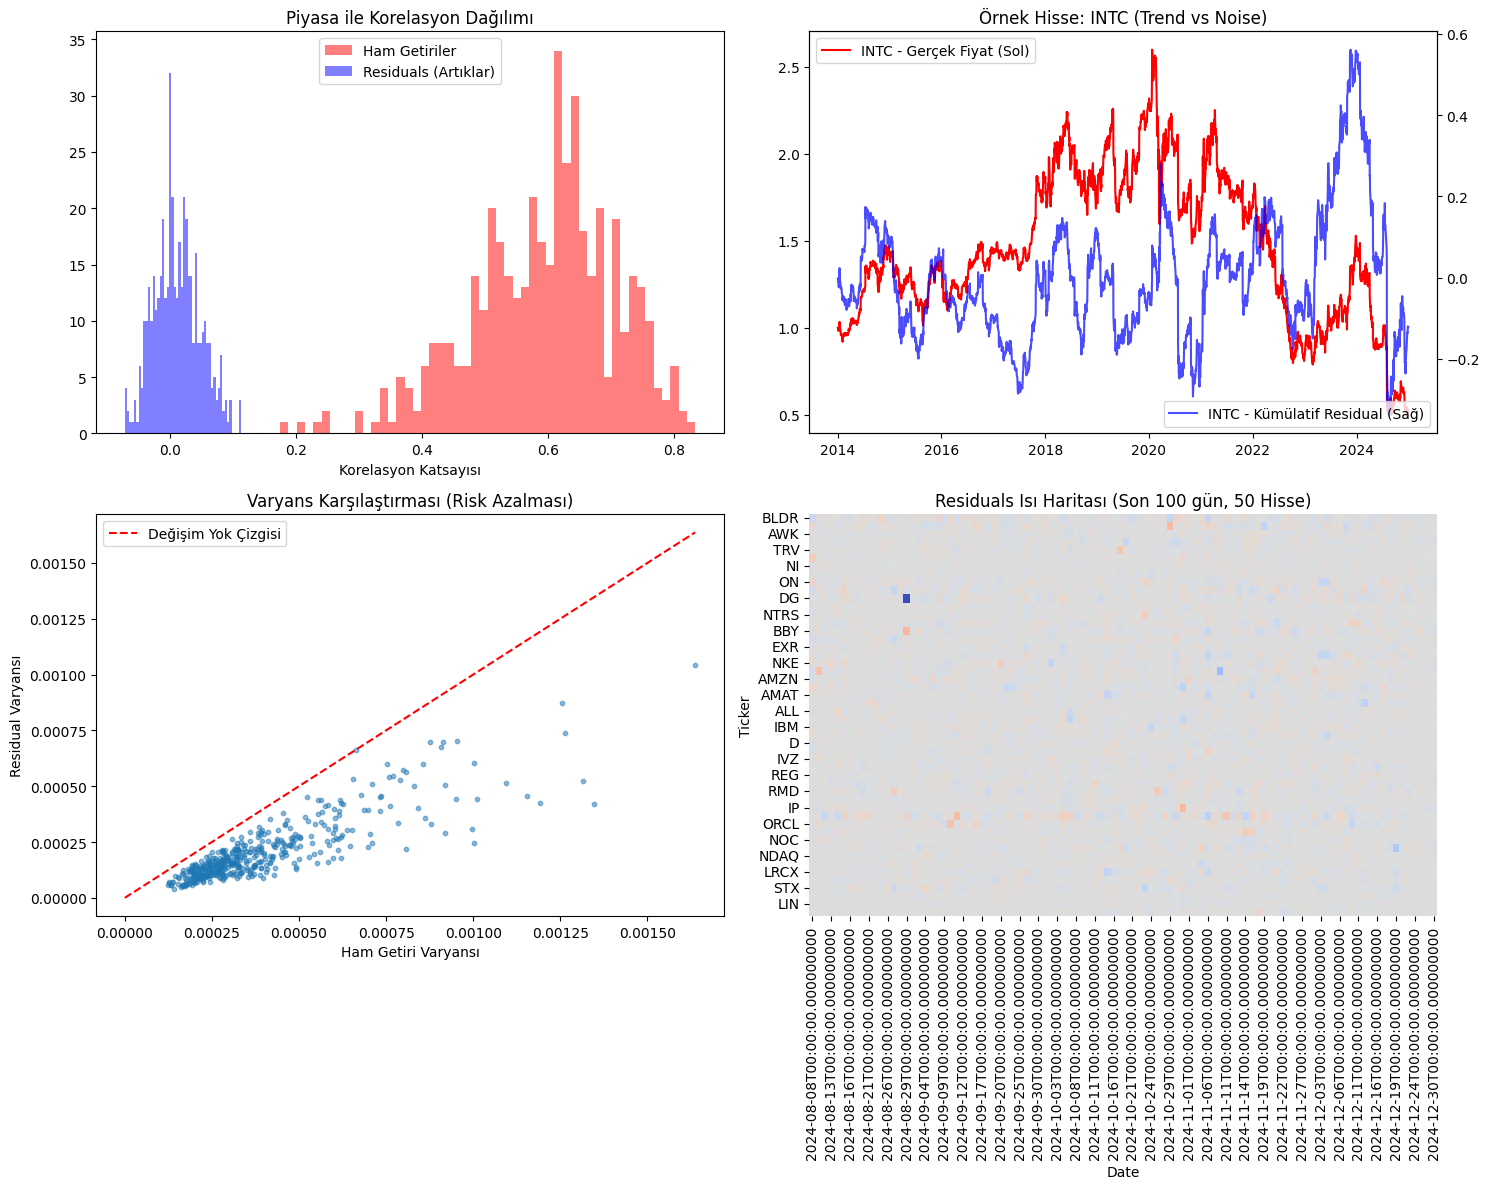

In [ ]:
#
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)